# Train-test split
Author: Michal Stary


In this notebook we perform train-test split of our original datasets' files. 
Since we need to cope with multiple records of most of the compounds, such a split needs to be done carefuly. 

In [10]:
# path to datasets
mona_path = "/storage/brno1-cerit/projects/msml/data/src/MoNA-export-GC-MS_Spectra.msp"
nist_path = "/storage/brno1-cerit/projects/msml/data/src/20210925_NIST_EI_MS_cleaned.msp"

In [11]:
import numpy as np

from matchms.importing import load_from_msp
from matchms.exporting import save_as_msp as save_as_msp_orig

# REDEFINE save_as_msp function to avoid problems with nested comments
def save_as_msp(ds, path):
    for rec in ds:
        if "comments" in rec.metadata:
            rec.set("comment", rec.get("comments"))
            rec._metadata.pop("comments")
    save_as_msp_orig(ds, path)

In [12]:
%%capture
mona = [*load_from_msp(mona_path, metadata_harmonization=False)]
nist = [*load_from_msp(nist_path, metadata_harmonization=False)]


In [13]:
data = dict()
data["mona"] = dict()
data["nist"] = dict()

In [14]:
# fix seed for now
np.random.seed(42)

## Naive solution - Random split
randomly assign into partitions

In [15]:
def random_split(size, split1=.8, split2=.9):
    split = int(size*split1)
    split2 = int(size*split2)

    ind = np.zeros(size)
    ind[split:split2] = 1
    ind[split2:] = 2

    
    np.random.shuffle(ind)

    train_ind = np.where(ind==0)[0]
    val_ind = np.where(ind==1)[0]
    test_ind = np.where(ind==2)[0]

    return train_ind, val_ind, test_ind

def get_sub(docs, indcs):
    return [docs[i] for i in indcs]

def do_random_split(mona, nist):
    data["mona"]["random_split_8_9"] = [get_sub(mona, indcs) for indcs in random_split(len(mona))]
    data["nist"]["random_split_8_9"] = [get_sub(nist, indcs) for indcs in random_split(len(nist))]

do_random_split(mona, nist)


### Notes
Unfortunately, the simple naive solution does not take in account the repetitive records of the same compound in dataset. 
As a result, the effect of such a split is that compounds present in test set can overlap with compounds in train set. This violates the standard splitting conditions. 

SCENARIO: I may or may not have the compound in DB, but it was measured imperfecly in experiment. 

# Advanced solutions
To simulate and assess performance without overlapping sets, we need to use records' attribute that represents what compound they represent.  

Records without this attribute are skipped for now.


In [23]:
# get mapping and first occurences of each unique compound
def get_map(ds, unkey="inchikey", parseuk_fn=lambda x: x):
    map_ = dict()
    dropped = 0
    for i, rec in enumerate(ds):
        if unkey not in rec.metadata or rec.metadata[unkey] == "nan":
            dropped +=1
            continue
        
        if parseuk_fn(rec.metadata[unkey]) not in map_:
            map_[parseuk_fn(rec.metadata[unkey])] = [rec]
        else:
            map_[parseuk_fn(rec.metadata[unkey])].append(rec)
            
    print(f"Dropped {dropped} out of {len(ds)} records due to missing unique key")
    return map_

print("**MONA***")
mona_map = get_map(mona, "inchikey")#, lambda x: x.split("-")[0])
print(f"Unique keys {len(mona_map)}")


print()
print("***NIST***")
nist_map = get_map(nist, "inchikey")#, lambda x: x.split("-")[0])
print(f"Unique keys {len(nist_map)}")


**MONA***
Dropped 6 out of 18898 records due to missing unique key
Unique keys 9858

***NIST***
Dropped 60163 out of 350618 records due to missing unique key
Unique keys 246910


## Put aside some compounds completely
put aside few compunds for the very ultimate evaluation of working with previously unseen compounds


We have 2 options how to do this:

1. remove all records of selected compounds from datasets 
2. use dedicated extra dataset and make sure that its compounds are not in the datasets

### First approach - select & remove

In [24]:
# random selection of compounds 
def select_random(ds_map, partition=.03):
    split = int(len(ds_map)*partition)
    ind = np.zeros(len(ds_map))
    ind[split:] = 1
    np.random.shuffle(ind)
    
    map_kept = dict()
    map_left = dict()
    for i, key in zip(ind, ds_map):
        if i != 0:
            map_kept[key] = ds_map[key]  
        else:
            map_left[key] = ds_map[key] 
            
    return map_kept, map_left

def do_select_random(mona_map, nist_map):
    mona_map, mona_map_left = select_random(mona_map)
    data["mona"]["left"] = [[item for sublist in mona_map_left.values() for item in sublist]]

    nist_map, nist_map_left = select_random(nist_map)
    data["nist"]["left"] = [[item for sublist in nist_map_left.values() for item in sublist]]

    return mona_map, nist_map

mona_map, nist_map = do_select_random(mona_map, nist_map)

### Second approach - obtain, check, (remove)
We will use small hi-res datasets from RECETOX

we can either remove mutual compounds from base datasets (MONA/NIST) or from these extra datasets. 

In [25]:
# path to extra datasets
rcx1_path = "/storage/brno1-cerit/projects/msml/data/src/recetox_gc-ei_ms_20201028.msp"
rcx2_path = "/storage/brno1-cerit/projects/msml/data/src/rcx_gc-orbitrap_metabolites_20210817.msp"


rcx1 = [*load_from_msp(rcx1_path, metadata_harmonization=False)]
rcx2 = [*load_from_msp(rcx2_path, metadata_harmonization=False)]

rcx1_map = get_map(rcx1, "inchikey")#, lambda x: x.split("-")[0])
rcx2_map = get_map(rcx2, "inchikey")#, lambda x: x.split("-")[0])



Dropped 0 out of 386 records due to missing unique key
Dropped 0 out of 265 records due to missing unique key


In [66]:
# substract from ds1 all records that have same InChiKey as any record in ds2
def substract_by_key(ds1_map, ds2_map):
    ds1_attr = set(ds1_map.keys())
    ds2_attr = set(ds2_map.keys())
    left_attr = ds1_attr.difference(ds2_attr)    
    #print(len(ds1_attr), len(left_attr))
    return left_attr

def keep_only_by_key(ds1_map, ds2_map):
    ds1_attr = set(ds1_map.keys())
    ds2_attr = set(ds2_map.keys())
    left_attr = ds1_attr.intersection(ds2_attr)    
    #print(len(ds1_attr), len(left_attr))
    return left_attr

def get_list_by_keys(keys, map_):
    res = []
    for key in keys:
        res += map_[key]
    return res

def do_small():
    data["mona"]["rcx1_no_mona"] = [get_list_by_keys(substract_by_key(rcx1_map, mona_map), rcx1_map)]
    data["mona"]["rcx2_no_mona"] = [get_list_by_keys(substract_by_key(rcx2_map, mona_map), rcx2_map)]
    
    data["nist"]["rcx1_no_nist"] = [get_list_by_keys(substract_by_key(rcx1_map, nist_map), rcx1_map)]
    data["nist"]["rcx2_no_nist"] = [get_list_by_keys(substract_by_key(rcx2_map, nist_map), rcx2_map)]
    
    data["nist"]["nist_rcx1_only"] = [get_list_by_keys(keep_only_by_key(rcx1_map, nist_map), nist_map)]
    data["nist"]["nist_rcx2_only"] = [get_list_by_keys(keep_only_by_key(rcx2_map, nist_map), nist_map)]
    
do_small()

In [67]:
[*map(len, data["nist"]["rcx1_no_nist"])], len(rcx1)

([62], 386)

In [68]:
[*map(len, data["nist"]["rcx2_no_nist"])], len(rcx2)

([155], 265)

In [96]:
rcx2[0].metadata

{'scannumber': '-1',
 'precursortype': '[M]+',
 'ionmode': 'Positive',
 'spectrumtype': 'Centroid',
 'formula': 'C18H30N2O2Si2',
 'inchikey': 'BITJWWNGDAOCJT-UHFFFAOYSA-N',
 'inchi': '',
 'smiles': 'C[Si](C)(C)Oc1cc2c(cc1)n(cc2CC\\N=C(/C)O)[Si](C)(C)C',
 'authors': 'Price et al., RECETOX, Masaryk University (CZ)',
 'instrument': 'Q Exactive GC Orbitrap GC-MS/MS',
 'instrumenttype': 'GC-EI-Orbitrap',
 'ionization': 'EI+',
 'license': 'CC BY-NC',
 'comment': '',
 'peak_comments': {73.04681: 'Theoretical m/z 73.046806, Mass diff 0 (0.05 ppm), SMILES C[Si+](C)C, Annotation [C3H9Si]+, Rule of HR True',
  76.01821: 'Theoretical m/z 76.018724, Mass diff 0 (0 ppm), Formula C5H2N',
  78.03387: 'Theoretical m/z 78.034374, Mass diff 0 (0 ppm), Formula C5H4N',
  79.04164: 'Theoretical m/z 79.042199, Mass diff 0 (0 ppm), Formula C5H5N',
  81.06992: 'Theoretical m/z 81.069878, Mass diff 0 (0.52 ppm), SMILES C1C[C+]2CCC12, Annotation [C6H9]+, Rule of HR True',
  89.03854: 'Theoretical m/z 89.039125, 

In [84]:
len(data["nist"]["nist_rcx2_only"][0])

288

In [38]:
nist_map[[*rcx1_map.keys()][0]][0].metadata

{'formula': 'C20D12',
 'mw': '264',
 'casno': '1520-96-3',
 'id': '153501',
 'comment': 'NIST MS# 118444, Seq# M269847',
 'inchi': 'InChI=1S/C20H12/c1-5-13-6-2-11-17-18-12-4-8-14-7-3-10-16(20(14)18)15(9-1)19(13)17/h1-12H/i1D,2D,3D,4D,5D,6D,7D,8D,9D,10D,11D,12D',
 'inchikey': 'CSHWQDPOILHKBI-AQZSQYOVSA-N',
 'iupac_name': '1,2,3,4,5,6,7,8,9,10,11,12-dodecadeuterioperylene',
 'smiles': 'C1=CC2=C3C(=C1)C4=CC=CC5=C4C(=CC=C5)C3=CC=C2',
 'num_peaks': '40',
 'compound_name': 'Perylene-D12'}

In [39]:
rcx1_map[[*rcx1_map.keys()][0]][0].metadata

{'scannumber': '-1',
 'precursortype': '[M]+',
 'ionmode': 'Positive',
 'spectrumtype': 'Centroid',
 'formula': 'C20H12',
 'inchikey': 'CSHWQDPOILHKBI-AQZSQYOVSA-N',
 'inchi': '',
 'smiles': '[2H]C1=C(C2=C3C(=C1[2H])C4=C(C(=C(C5=C4C(=C(C(=C5[2H])[2H])[2H])C3=C(C(=C2[2H])[2H])[2H])[2H])[2H])[2H])[2H]',
 'authors': 'Price et al., RECETOX, Masaryk University (CZ)',
 'instrument': 'Q Exactive GC Orbitrap GC-MS/MS',
 'instrumenttype': 'GC-EI-Orbitrap',
 'ionization': 'EI+',
 'license': 'CC BY-NC',
 'comment': '',
 'num_peaks': '33',
 'compound_name': 'Perylene_2H12',
 'retention_time': '-1',
 'retention_index': '2876',
 'precursor_mz': '264.16858',
 'collision_energy': '70eV'}

In [41]:
from matchms.plotting import plot_spectra_mirror

<AxesSubplot:title={'center':'Spectrum comparison'}, xlabel='m/z', ylabel='Intensity'>

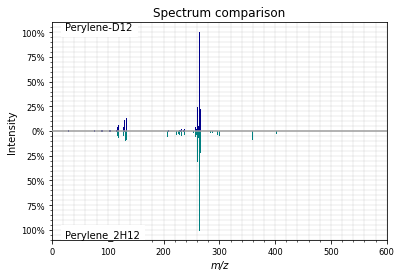

In [45]:
plot_spectra_mirror(nist_map[[*rcx1_map.keys()][0]][0], rcx1_map[[*rcx1_map.keys()][0]][0])

In [55]:
from rdkit import Chem

smis = [nist_map[[*rcx1_map.keys()][0]][0].metadata["smiles"],
          rcx1_map[[*rcx1_map.keys()][0]][0].metadata["smiles"]]

cans = [Chem.MolToSmiles(Chem.MolFromSmiles(smi), True) for smi in smis]
cans[0],cans[1]

# Chem.MolToInchiKey

('c1cc2cccc3c4cccc5cccc(c(c1)c23)c54',
 '[2H]c1c([2H])c2c([2H])c([2H])c([2H])c3c4c([2H])c([2H])c([2H])c5c([2H])c([2H])c([2H])c(c(c1[2H])c23)c54')

In [64]:
nist_map[[*rcx1_map.keys()][5]][0].metadata

{'formula': 'C12H8',
 'mw': '152',
 'casno': '208-96-8',
 'id': '29521',
 'comment': 'SemiStdNP=1455/10/22 StdNP=1426/8/14 StdPolar=2191/3/2 ; NIST MS# 228341, Seq# M177049 |RI:1460|',
 'inchi': 'InChI=1S/C12H8/c1-3-9-4-2-6-11-8-7-10(5-1)12(9)11/h1-8H',
 'inchikey': 'HXGDTGSAIMULJN-UHFFFAOYSA-N',
 'iupac_name': 'acenaphthylene',
 'smiles': 'C1=CC2=C3C(=C1)C=CC3=CC=C2',
 'num_peaks': '58',
 'compound_name': 'Acenaphthylene',
 'retention_index': '1460'}

In [65]:
rcx1_map[[*rcx1_map.keys()][5]][0].metadata

{'scannumber': '-1',
 'precursortype': '[M]+',
 'ionmode': 'Positive',
 'spectrumtype': 'Centroid',
 'formula': 'C12H8',
 'inchikey': 'HXGDTGSAIMULJN-UHFFFAOYSA-N',
 'inchi': '',
 'smiles': 'C1=CC2=C3C1=CC=CC3=CC=C2',
 'authors': 'Price et al., RECETOX, Masaryk University (CZ)',
 'instrument': 'Q Exactive GC Orbitrap GC-MS/MS',
 'instrumenttype': 'GC-EI-Orbitrap',
 'ionization': 'EI+',
 'license': 'CC BY-NC',
 'comment': '',
 'peak_comments': {74.01511: 'Theoretical m/z 74.01565, Mass diff 0 (0 ppm), Formula C6H2',
  75.02295: 'Theoretical m/z 75.023475, Mass diff 0 (0 ppm), Formula C6H3',
  76.03077: 'Theoretical m/z 76.0313, Mass diff 0 (0 ppm), Formula C6H4',
  77.03858: 'Theoretical m/z 77.039125, Mass diff 0 (0 ppm), Formula C6H5',
  86.01511: 'Theoretical m/z 86.01565, Mass diff 0 (0 ppm), Formula C7H2',
  87.02298: 'Theoretical m/z 87.023475, Mass diff 0 (0 ppm), Formula C7H3',
  91.05425: 'Theoretical m/z 91.054775, Mass diff 0 (0 ppm), Formula C7H7',
  92.06201: 'Theoretical m

In [58]:
from matchms.plotting import plot_spectra_mirror

<AxesSubplot:title={'center':'Spectrum comparison'}, xlabel='m/z', ylabel='Intensity'>

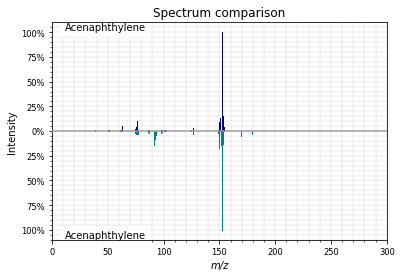

In [62]:
plot_spectra_mirror(nist_map[[*rcx1_map.keys()][5]][0], rcx1_map[[*rcx1_map.keys()][5]][0])

In [63]:
from rdkit import Chem

smis = [nist_map[[*rcx1_map.keys()][5]][0].metadata["smiles"],
          rcx1_map[[*rcx1_map.keys()][5]][0].metadata["smiles"]]

cans = [Chem.MolToSmiles(Chem.MolFromSmiles(smi), True) for smi in smis]
cans[0],cans[1]

# Chem.MolToInchiKey

('C1=Cc2cccc3cccc1c23', 'C1=Cc2cccc3cccc1c23')

# Scenario 2 - dealing solely with known compounds
Firstly, we divide our dataset into train-val-test partitions to simulate prediction of missing parts of compounds that are part of our database.

We do that by leveraging the duplicity of compounds in dababases:
        
    All first occurences of compounds in dataset are put into train set
    Left out records are then splitted by compounds and put into validation and test sets. 

In [11]:
def get_sub_nested(map_, indcs):
    keys = np.array(list(map_.keys()))[indcs]
    return [item for sublist in [map_[i] for i in keys] for item in sublist]

def get_first_others(ds_map):
    first = []
    others_map = dict()
    for key in ds_map:
        first.append(ds_map[key][0])
        if len(ds_map[key]) > 1:
            others_map[key] = ds_map[key][1:]
    return first, others_map

def do_first_others_split(mona_map, nist_map):
    mona_first, mona_others_map = get_first_others(mona_map)
    nist_first, nist_others_map = get_first_others(nist_map)
    
    # split by compounds
    mona_others_ind = random_split(len(mona_others_map.keys()), 0,.5)
    nist_others_ind = random_split(len(nist_others_map.keys()), 0,.5)
    
    data["mona"]["in_database"] = [mona_first] + [get_sub_nested(mona_others_map, indcs) for indcs in mona_others_ind][1:]
    data["nist"]["in_database"] = [nist_first] + [get_sub_nested(nist_others_map, indcs) for indcs in nist_others_ind][1:]

do_first_others_split(mona_map, nist_map)

# Scenario 3 - dealing solely with unknown compounds
Secodly, we divide our dataset into train-val-test partitions to simulate prediction of missing parts of compounds that are not in our database.

    Dataset is splitted so either only one record per compound is kept or that repetetive records of the same compound are only in one partition. 

## Keep unique only random split
keeps only first occurence of each compound in ds

randomly assign into partitions

In [12]:
split_mona = random_split(len(mona_map))
split_nist = random_split(len(nist_map))

In [13]:
def get_first_occ(ds_map):
    first = []
    for key in ds_map:
        first.append(ds_map[key][0])
    return first

def do_first_only_random_split(mona_map, nist_map):
    data["mona"]["unique_inchi"] = [get_sub(get_first_occ(mona_map), indcs) for indcs in split_mona]
    data["nist"]["unique_inchi"] = [get_sub(get_first_occ(nist_map), indcs) for indcs in split_nist]

do_first_only_random_split(mona_map, nist_map)

## Duplicates in set only split
assure that duplicate records of any compounds occurs only in one partition

SCENARIO: I DO NOT have the compound in DB, but it was measured imperfecly in experiment and.

In [14]:


def do_duplicates_in_partition_only_split(mona_map, nist_map):
    data["mona"]["de_novo"] = [get_sub_nested(mona_map, indcs) for indcs in split_mona]
    data["nist"]["de_novo"] = [get_sub_nested(nist_map, indcs) for indcs in split_nist]

do_duplicates_in_partition_only_split(mona_map, nist_map)

## Inspections

In [15]:
mona[1].metadata

{'name': '2,4-DINITROPHENOL',
 'synon': '$:00in-source',
 'db#': 'JP000002',
 'inchikey': 'UFBJCMHMOXMLKC-UHFFFAOYSA-N',
 'spectrum_type': 'MS1',
 'instrument_type': 'EI-B',
 'instrument': 'VARIAN MAT-44',
 'ion_mode': 'P',
 'formula': 'C6H4N2O5',
 'mw': '184',
 'exactmass': '184.01202122799998',
 'smiles': '[O-1][N+1](=O)c(c1)cc([N+1]([O-1])=O)c(O)c1',
 'inchi': 'InChI=1S/C6H4N2O5/c9-6-2-1-4(7(10)11)3-5(6)8(12)13/h1-3,9H',
 'computed smiles': 'C1=C(C=C(C(=C1)O)N(=O)=O)N(=O)=O',
 'accession': 'JP000002',
 'date': '2016.01.19 (Created 2008.10.21, modified 2011.05.06)',
 'author': 'KOGA M, UNIV. OF OCCUPATIONAL AND ENVIRONMENTAL HEALTH',
 'license': 'CC BY-NC-SA',
 'exact mass': '184.01202',
 'ionization energy': '70 eV',
 'ion type': '[M]+*',
 'splash': 'splash10-0w33-9300000000-b1719d21caddddc047cb',
 'submitter': 'University of Tokyo Team (Faculty of Engineering, University of Tokyo)',
 'mona rating': '3.75',
 'num peaks': '64'}

In [16]:
data["nist"].keys()

dict_keys(['random_split_8_9', 'left', 'rcx1_no_nist', 'rcx2_no_nist', 'in_database', 'unique_inchi', 'de_novo'])

In [17]:
[*map(len, data["nist"]["random_split_8_9"])]

[280494, 35062, 35062]

In [18]:
[*map(len,data["nist"]["de_novo"])]

[225611, 28108, 27980]

In [19]:
[*map(len,data["nist"]["in_database"])]

[236111, 22978, 22610]

In [20]:
from collections import Counter

print("(n, k) tuples, where n=number of duplicates and k=number of compounds with k duplicates")
Counter([len(nist_map[k]) for k in nist_map]).most_common()


(n, k) tuples, where n=number of duplicates and k=number of compounds with k duplicates


[(1, 210330),
 (2, 15066),
 (3, 5629),
 (4, 2847),
 (5, 1447),
 (6, 427),
 (7, 153),
 (9, 69),
 (8, 58),
 (10, 34),
 (11, 14),
 (12, 14),
 (13, 10),
 (14, 4),
 (19, 3),
 (15, 2),
 (17, 2),
 (24, 1),
 (16, 1)]

In [94]:
data["nist"].keys()
# data["nist"].pop("left")

dict_keys(['rcx1_no_nist', 'rcx2_no_nist', 'nist_rcx1_only', 'nist_rcx2_only'])

## Save into files

In [95]:
import os
def save(data, path):
    for ds in data:
        #os.makedirs(path + ds, exist_ok=True)
        for kind in data[ds]:
            os.makedirs(f"{path}/{ds}/{kind}", exist_ok=True)
            for part, recs in zip(["train", "val", "test"], data[ds][kind]):
                save_as_msp(recs, f"{path}/{ds}/{kind}/{part}.msp")

save(data, "/storage/brno2/home/xstary1/brno6/missing-peaks-prediction/data")
#save(data, "/storage/brno1-cerit/projects/msml/data/split")

In [85]:
!pwd

/auto/brno2/home/xstary1/brno6/missing-peaks-prediction/preprocessing
